# Linear mixed model

Linear mixed model (LMM) is a powerful statistical modeling tool in settings where repeated measurements are made on the same statistical units, or where measurements are made on clusters of related statistical units. 

Specifically, consider the following linear mixed model with $n$ clusters and each cluster $i$ has $m_i$ obesrvations such that
$$y_i=X^i\beta^*+Z^i\gamma_i+\epsilon_i, i=1,\cdots,n$$
where $y_i\in\mathbb{R}^{m_i}$, $X^{i}\in\mathbb{R}^{m_i\times p}$, $Z^{i}\in\mathbb{R}^{m_i\times q}$  are the response vector, fixed effects design matrix, random effects design matrix of th $i$-th cluster respectively and $\beta^*\in\mathbb{R}^p$ is the unknown fixed effects and $\gamma_i\in\mathbb{R}^q\overset{i.i.d.}{\sim}(0, \Psi)$ are unknown random effects, $\epsilon_i\in\mathbb{R}^{m_i}\overset{i.i.d.}{\sim}(0, \sigma^2I)$ are noise vectors. $\beta^*$.
Alternatively, it can be written in the matrix form $y=X\beta^*+Z\gamma+\epsilon$  that
$$
    \begin{bmatrix} y_1 \\ y_2\\ \vdots \\ y_n \end{bmatrix}=
    \begin{bmatrix} X^1 \\ X^2\\ \vdots \\ X^n \end{bmatrix}\beta^* + 
    \begin{bmatrix} & Z^1 & 0 &\cdots & 0 \\ & 0 & Z^2 &\cdots & 0\\ & \vdots & \vdots & & \vdots\\ & 0 & 0 &\cdots & Z^n  \\\end{bmatrix}
    \begin{bmatrix} \gamma_1 \\ \gamma_2\\ \vdots \\ \gamma_n \end{bmatrix}+
    \begin{bmatrix} \epsilon_1 \\ \epsilon_2\\ \vdots \\ \epsilon_n \end{bmatrix}.
$$


Here, we only focus on the estimation of the fixed effect $\beta^*$. In fact, LLM can be viewed as the linear model $y_i=X^i\beta^*+\xi_i$ with correlated noise $\xi_i\overset{i.i.d.}{\sim} (0, Z^i\Psi(Z^i)^{\top}+\sigma^2 I)$ and this unknown parameter $\Psi, \sigma^2$ bring much challenge for the estimation of $\beta^*$.
A simple but efficient quasi-likelihood framework is proposed by [Li, Cai and Li (2022).](https://www.tandfonline.com/doi/abs/10.1080/01621459.2021.1888740?journalCode=uasa20) which constructed a proxy covariance matrix $\Sigma_a$ and then transformed the original data $(X,y)$ to $(X_a, y_a):=(\Sigma_{a}^{-1/2}X,\Sigma_{a}^{-1/2}y)$ to eliminate the within-cluster correlation structure. Thus, usual estimation approaches in linear models can be used to $(X_a, y_a)$. 

Specifically, for a pre-defined positive constant $a>0$, we define the proxy of the covariance matrix $\Sigma_a\in\mathbb{R}^{N\times N}$ with its diagonal block being $\Sigma_a^i:=aZ^i(Z^i)^{\top}+I_{m_i}$ where $N=\sum_{i=1}^n m_i$. Then, we transform original data $(X,y)$ to $(X_a, y_a):=(\Sigma_{a}^{-1/2}X,\Sigma_{a}^{-1/2}y)$ and solve the following sparse regression using ``scope``
$$
\hat{\beta}=\arg\min_{\beta\in\mathbb{R}^p}\frac{1}{2\text{trace}(\Sigma_a^{-1})}\|y_a-X_a\beta\|_2^2 \text{ s.t. } \|\beta\|_0\leq k.
$$

 In the following example, we set $p=50, q=4, n=15, m_1=\cdots=m_n=8$ and thus $N=m\times n=120$ and $\|\beta^*\|_0=3$ with its nonzero components being $(1, 0.5, 0.3)$. Rows of design matrices $X^i$ and $Z^i$ are generated from Gaussian distribution with mean and covariance structure specificed in the following code.

In [72]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from scope import ScopeSolver

import warnings
warnings.filterwarnings('ignore')

In [73]:
def make_data(m=8, n=30, p=300, q=8, sigma=0.25, rho=0.2, seed=0):
    '''
    m: number of observations of each cluster
    n: number of clusters
    p: dimension of fixed effect
    q: dimension of random effect
    '''
    N = m * n
    rng = np.random.default_rng(seed)
    
    def func(i, j):
        m = np.maximum(i, j)
        return np.where(m<=q-1, rho**(abs(i-j)), 0)
    Sigma_xz = np.fromfunction(func, (p, q))  # covariance between X and Z
    
    Sigma = np.block([[np.eye(p), Sigma_xz],
                      [Sigma_xz.T, np.eye(q)]])
    
    X_Z = rng.multivariate_normal(np.zeros(p+q), Sigma, size=N)
    X, Z_stack = X_Z[:, :p], X_Z[:, p:]
    Z = np.zeros((N, n*q))
    for i in range(n):
        Z[(i*m):((i+1)*m), (i*q):((i+1)*q)] = Z_stack[(i*m):((i+1)*m), :]

    beta = np.zeros(p)
    beta[[1, 5, 10]] = [1, 5, 3]
    Psi = np.fromfunction(lambda i, j: 0.56**(abs(i-j)), (q, q))  # covariance of random effect gamma
    gamma = np.ravel(rng.multivariate_normal(np.zeros(q), Psi, size=n))  # concate n random effect gamma_i

    noise = rng.normal(size=N) * 0.25
    y = X @ beta + Z @ gamma + noise
    return X, Z, Z_stack, y, beta, gamma


m, n, p, q = 8, 15, 200, 4
N = m * n
X, Z, Z_stack, y, beta, gamma = make_data(m=m, n=n, p=p, q=q, seed=0)
print('X shape: ', X.shape)
print('Z shape: ', Z.shape)

X shape:  (120, 200)
Z shape:  (120, 60)


In [74]:
def lmm_scope(X, Z, y, m, a, k):
    N, p = X.shape
    q = Z.shape[1]
    n = int(N / m)

    Sigma_a = np.zeros((N, N))
    for i in range(n):
        Z_i = Z[(i*m):((i+1)*m), :]
        Sigma_a[(i*m):((i+1)*m), (i*m):((i+1)*m)] = a * Z_i @ Z_i.T + np.eye(m)
    w, v = np.linalg.eig(Sigma_a)
    w, v = np.real(w), np.real(v)
    L = v @ np.diag(w **(-0.5)) @ v.T  # normalized matrix
    X_a, y_a = L @ X, L @ y

    def custom_objective(params):
        loss = jnp.sum((y_a - X_a @ params) ** 2) / jnp.trace(v @ np.diag(w **(-1)) @ v.T)
        return loss
    
    solver = ScopeSolver(p, k)
    params = solver.solve(custom_objective)
    loss = np.mean((y_a - X_a @ params) ** 2)
    return params, loss

In [75]:
# cross validation w.r.t a
a_list = np.arange(0, 10, 1)
loss_best = None
beta_list, loss_list = [], []
for a in a_list:
    beta_a, loss_a = lmm_scope(X, Z, y, m=m, a=a, k=3)
    if (loss_best is None) or (loss_a < loss_best):
        a_best = a
        beta_best = beta_a

In [76]:
true_support = np.nonzero(beta)[0]
estimated_support = np.nonzero(beta_best)[0]

print('Accurate sparse recovery: ', (true_support == estimated_support).all())
print('True fixed effect: ', beta[true_support])
print('Estimated fixed effect: ', beta_best[estimated_support].round(3))

Accurate sparse recovery:  True
True fixed effect:  [1. 5. 3.]
Estimated fixed effect:  [1.069 4.957 2.933]


In [77]:
# compared with the mlm estimator
from statsmodels.regression.mixed_linear_model import MixedLM as mlm
groups = []
for i in range(n):
    groups += [i] * m

model = mlm(endog=y, exog=X, groups=groups, exog_re=Z_stack)
result = model.fit()
print('Error of MixedLM: ', np.linalg.norm(result.fe_params - beta).round(3))
print('Error of scope: ', np.linalg.norm(beta_best - beta).round(3))

Error of MixedLM:  27.032
Error of scope:  0.105


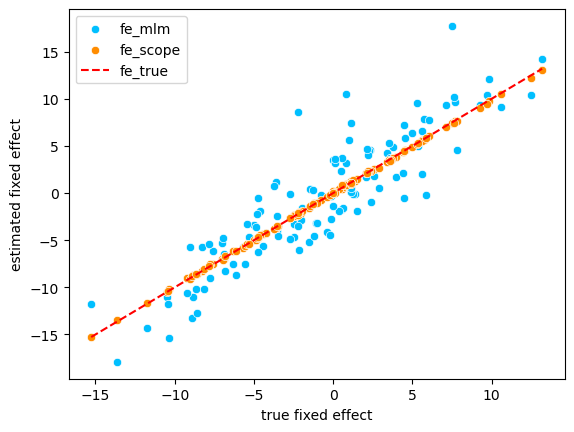

In [80]:
# evaluate the quality of the recovery of fixed effect
fe_true = X @ beta
fe_mlm =  X @ result.fe_params
fe_scope = X @ beta_best

sns.scatterplot(x=fe_true, y=fe_mlm, label='fe_mlm', color='deepskyblue')
sns.scatterplot(x=fe_true, y=fe_scope, label='fe_scope', color='darkorange')
sns.lineplot(x=fe_true, y=fe_true, label='fe_true', color='red', linestyle='--')

plt.xlabel('true fixed effect')
plt.ylabel('estimated fixed effect')
plt.legend()
plt.show()

# Reference

- Mixed model. https://en.wikipedia.org/wiki/Mixed_model
  
- Li S, Cai T T, Li H. Inference for high-dimensional linear mixed-effects models: A quasi-likelihood approach[J]. Journal of the American Statistical Association, 2022, 117(540): 1835-1846.